In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))

In [2]:
using ATools
using Configurations
using DataFrames
using Distributions
using Glob
using HDF5
using Logging
using Plots
using Statistics
using StatsBase
using Unitful

import Unitful: ps

In [3]:
@option struct CalConfig
  input_dir::String
  conf_dir ::String
  plot_dir ::String
  qmin     ::Float32
  qmax     ::Float32
  save_cal ::Bool = false
end

In [5]:
## Change the configuration .toml to change the input and cuts.
config_file = "../config/cal_n5_20mm.toml"
conf        = from_toml(CalConfig, config_file)

CalConfig("../data/", "n5-dz1m-LXe20mm-noQrz-4-magic/", "plot_dir", 1900.0f0, 2200.0f0, true)

In [6]:
## Basic setup: Variables shouold be adjusted for each relevant run
# normalisation: number of decays simulated, should be saved somewhere!
# rmin         : Ring minimum r
# rmax         : Ring maximum r
# in_dir       : directory where the output folders of makenema.jl are.
# config       : subdirectory for input/output
# plot_dir     : base directory for plots
in_dir    = conf.input_dir
config    = conf.conf_dir
plot_dir  = conf.plot_dir
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

"plot_dir/n5-dz1m-LXe20mm-noQrz-4-magic/"

In [7]:
in_path

"../data/n5-dz1m-LXe20mm-noQrz-4-magic/"

In [8]:
norm, rmin, rmax, ndf = read_evtpar(glob("*.h5", in_path))
println(norm, " simulated events, ", nrow(ndf), " with two interactions: ", 100 * nrow(ndf) / norm, "%")

1500000 simulated events, 215513 with two interactions: 14.367533333333334%


# Check on total charge

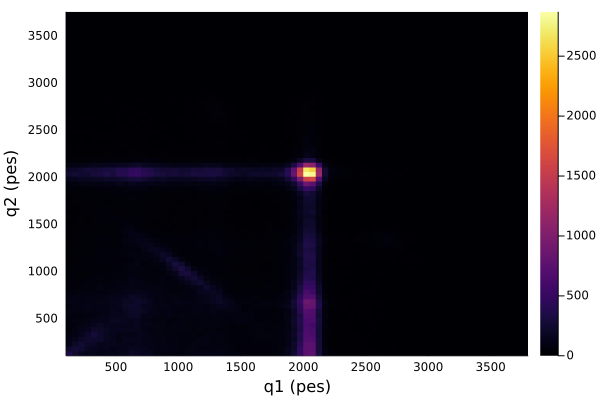

In [9]:
q1min, q1max = (minimum(ndf.q1), maximum(ndf.q1))
q2min, q2max = (minimum(ndf.q2), maximum(ndf.q2))
_, pq1q2 = hist2d(ndf.q1, ndf.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2)

In [10]:
interval = ATools.range_bound(conf.qmin, conf.qmax, ATools.OpenBound)
ndfq = filter(x -> broadcast(interval, x.q1) .& broadcast(interval, x.q2), ndf)
println("Photoelectric charge cut leaves ", nrow(ndfq) / nrow(ndf), " of the double interactions, ", nrow(ndfq) / norm, "% of simulated events.")

Photoelectric charge cut leaves 0.14664544598237694 of the double interactions, 0.021069333333333332% of simulated events.


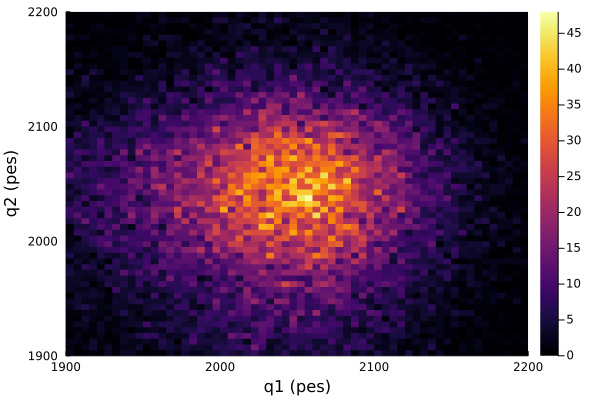

In [11]:
_, pq1q2_f = hist2d(ndfq.q1, ndfq.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2_f)

# Combine the two hemispheres for calibration

In [12]:
function combined_std(df::DataFrame, stdz::Symbol, stdphi::Symbol)
  sqrt.(df[!, stdz].^2 + (rmax .* df[!, stdphi]).^2)
end

combined_std (generic function with 1 method)

In [13]:
ring_df = DataFrame(:r => vcat(ndfq.r1, ndfq.r2), :nsipm => vcat(ndfq.nsipm1, ndfq.nsipm2), :zstd => vcat(ndfq.zstd1, ndfq.zstd2), :phistd => vcat(ndfq.phistd1, ndfq.phistd2))
## Add a column with the combination of the two axes
ring_df[!, "stdrad"] = combined_std(ring_df, :zstd, :phistd);

## Correlations between the size of the area of charge seen and the interaction radius

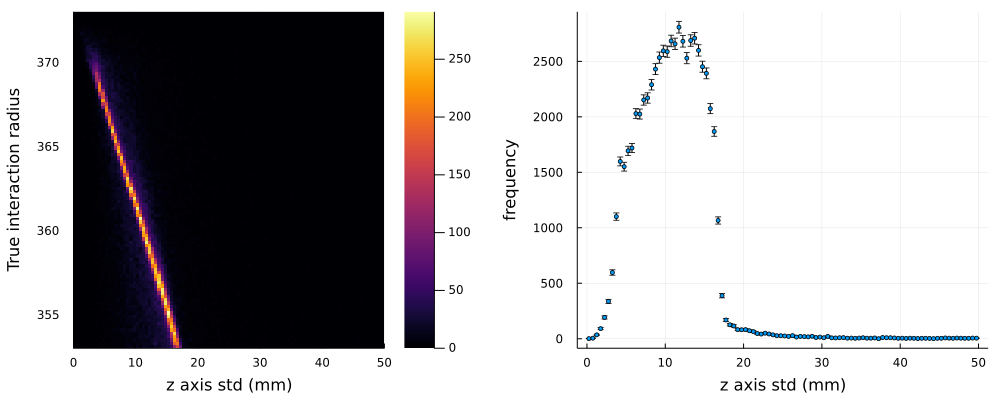

In [14]:
_, pzr = hist2d(ring_df.zstd, ring_df.r, 100, "z axis std (mm)", "True interaction radius", 0.0f0, 50.0f0, 350.0f0, 400.0f0)
hz, pz  = hist1d(ring_df.zstd, "z axis std (mm)", 100, 0.0f0, 50.0f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pzr, pz, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [15]:
zmax, _ = findmax(hz.weights)
useful_bins = findall(x -> x >= 0.1 * zmax, hz.weights)
nbinszpr = useful_bins[end] - useful_bins[1] + 1
minzpr   = edges(hz)[useful_bins[1]]
maxzpr   = edges(hz)[useful_bins[end] + 1]

17.5f0

proportion of selected events in fit range: 0.965162637640805
Fit parameters: a = 373.8252802120182, b = -1.2193965281960017
Fit errors: a = 0.094630749701503 b = 0.008685742471190932


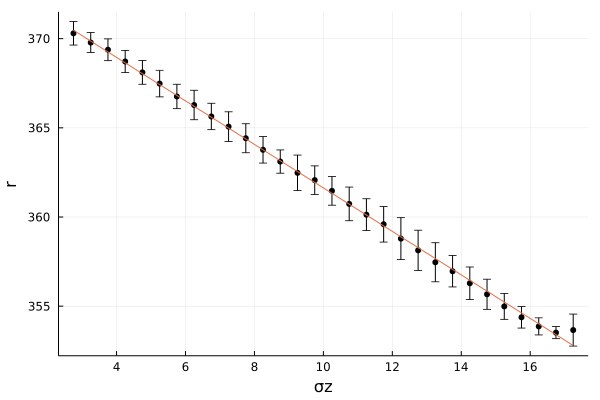

In [16]:
mask_std = (ring_df.zstd .>= minzpr) .& (ring_df.zstd .< maxzpr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fzr, pzr = fit_profile(ring_df[mask_std, :zstd], ring_df[mask_std, :r], "σz", "r", "pol1", nbinszpr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fzr.fitpar
fstds = fzr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr)

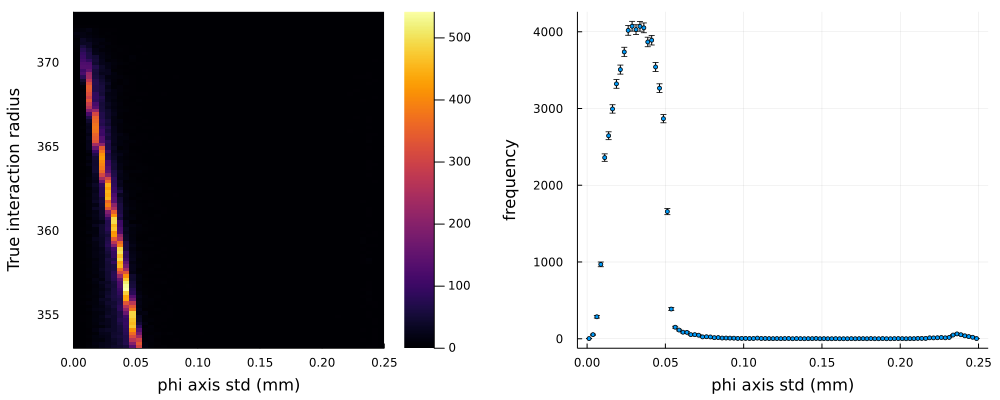

In [17]:
_, ppr = hist2d(ring_df.phistd, ring_df.r, 100, "phi axis std (mm)", "True interaction radius", 0.0f0, 0.25f0, 350.0f0, 400.0f0)
hp, pp  = hist1d(ring_df.phistd, "phi axis std (mm)", 100, 0.0f0, 0.25f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(ppr, pp, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [18]:
pmax, _ = findmax(hp.weights)
useful_bins = findall(x -> x >= 0.1 * pmax, hp.weights)
nbinsppr = useful_bins[end] - useful_bins[1] + 1
minppr   = edges(hp)[useful_bins[1]]
maxppr   = edges(hp)[useful_bins[end] + 1]

0.0525f0

proportion of selected events in fit range: 0.9312112390836603
Fit parameters: a = 373.1899833466839, b = -391.0854736996675
Fit errors: a = 0.08841518617836955 b = 2.7054354947215025


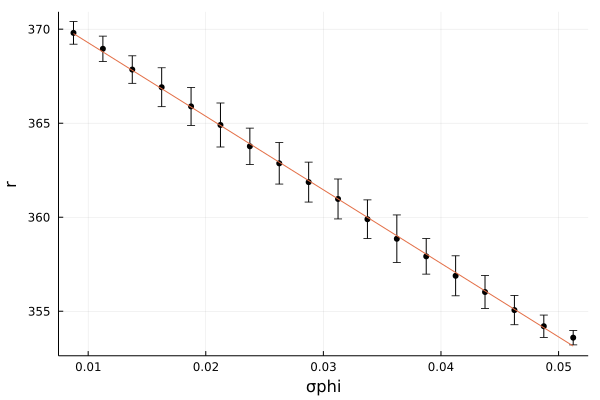

In [19]:
mask_std = (ring_df.phistd .>= minppr) .& (ring_df.phistd .< maxppr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fpr, ppr = fit_profile(ring_df[mask_std, :phistd], ring_df[mask_std, :r], "σphi", "r", "pol1", nbinsppr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fpr.fitpar
fstds = fpr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr)

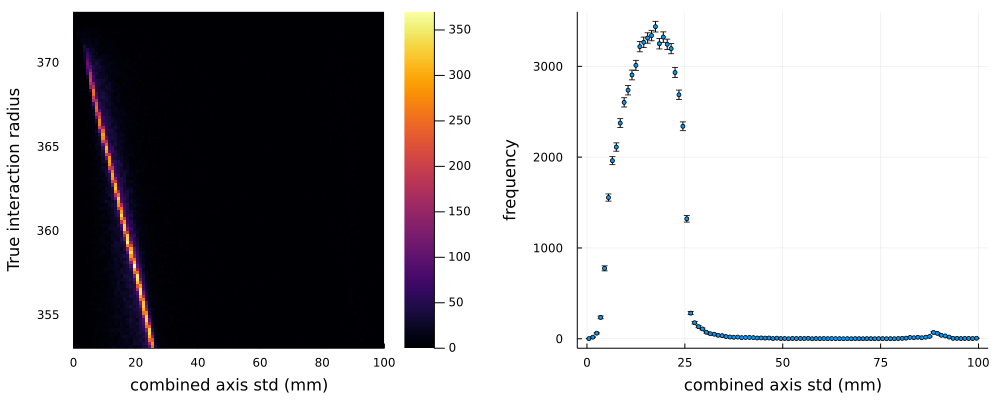

In [20]:
_, pcr = hist2d(ring_df.stdrad, ring_df.r, 100, "combined axis std (mm)", "True interaction radius", 0.0f0, 100.0f0, 350.0f0, 400.0f0)
hc, pc  = hist1d(ring_df.stdrad, "combined axis std (mm)", 100, 0.0f0, 100.0f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pcr, pc, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [21]:
cmax, _ = findmax(hc.weights)
useful_bins = findall(x -> x >= 0.1 * cmax, hc.weights)
nbinscpr = useful_bins[end] - useful_bins[1] + 1
mincpr   = edges(hc)[useful_bins[1]]
maxcpr   = edges(hc)[useful_bins[end] + 1]

26.0f0

proportion of selected events in fit range: 0.9317175041134034
Fit parameters: a = 373.57339305631484, b = -0.8005369585530829
Fit errors: a = 0.047156467033468645 b = 0.00289501777892912


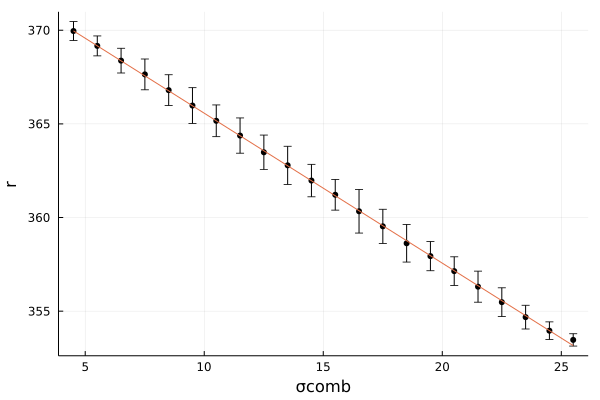

In [22]:
mask_std = (ring_df.stdrad .>= mincpr) .& (ring_df.stdrad .< maxcpr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fcr, pcr = fit_profile(ring_df[mask_std, :stdrad], ring_df[mask_std, :r], "σcomb", "r", "pol1", nbinscpr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fcr.fitpar
fstds = fcr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr)

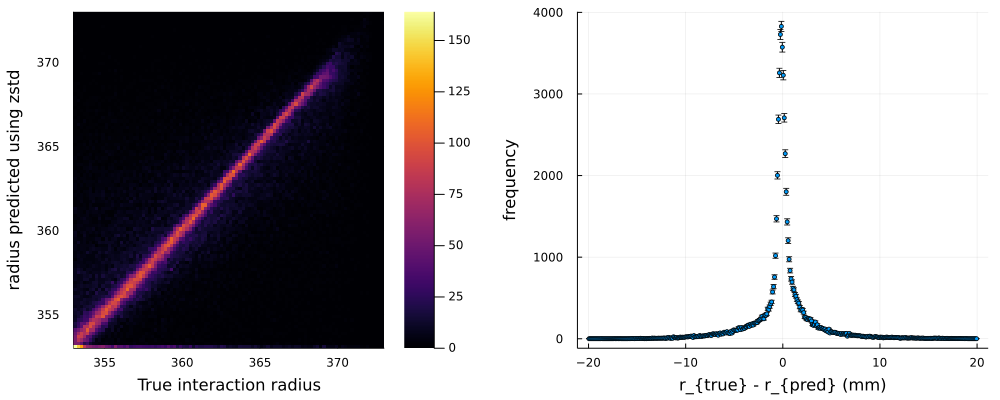

In [23]:
zpredr = ATools.predict_interaction_radius(fzr.g, rmin, rmax)(ring_df.zstd)
_, pRzres = hist2d(ring_df.r, Float32.(zpredr), 100, "True interaction radius", "radius predicted using zstd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hzres, pzres  = hist1d(Float32.(ring_df.r - zpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRzres, pzres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.12478082939317943, 0.3556294289982468, 2.440931305294764


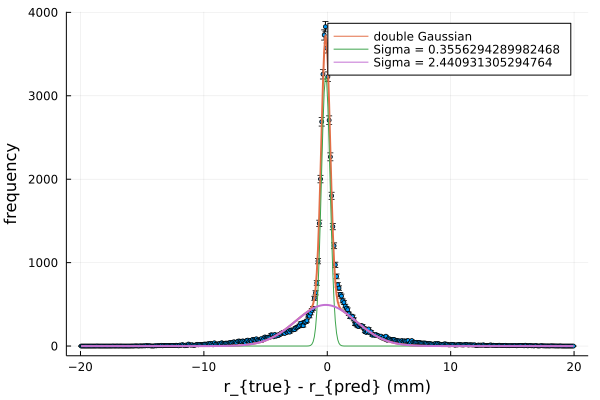

In [24]:
x_vals = ATools.centers(hzres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hzres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hzres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hzres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hzres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hzres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hzres.weights) * 100, sigma_all * 100]
p0 = [sum(hzres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hzres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hzres.weights), p0, lb, ub)

fitmeanz = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanz, ", ", sigma1, ", ", sigma2)
pzres = plot!(pzres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
pzres = plot!(pzres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
pzres = plot!(pzres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(pzres)

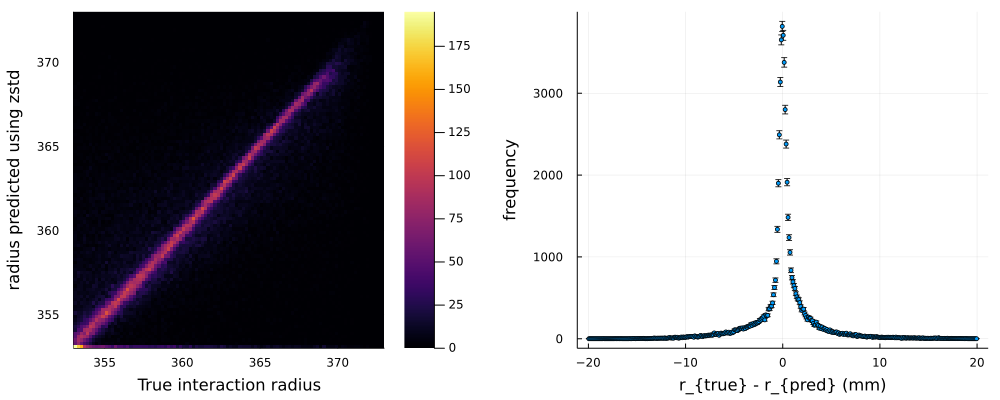

In [25]:
zpredr = ATools.predict_interaction_radius(fzr.g, rmin, rmax, fitmeanz)(ring_df.zstd)
_, pRzres = hist2d(ring_df.r, Float32.(zpredr), 100, "True interaction radius", "radius predicted using zstd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hzres, pzres  = hist1d(Float32.(ring_df.r - zpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRzres, pzres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

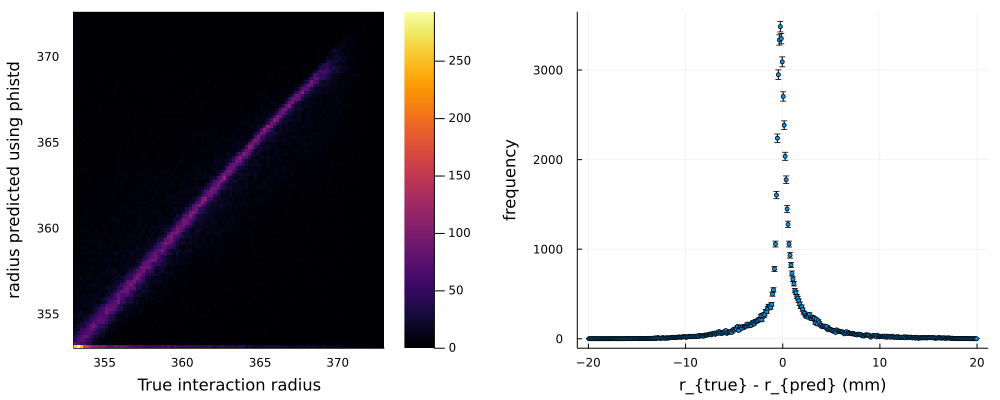

In [26]:
ppredr = ATools.predict_interaction_radius(fpr.g, rmin, rmax)(ring_df.phistd)
_, pRpres = hist2d(ring_df.r, Float32.(ppredr), 100, "True interaction radius", "radius predicted using phistd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hpres, ppres  = hist1d(Float32.(ring_df.r - ppredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRpres, ppres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.15098687416605938, 0.3928809019682321, 2.8009261271573314


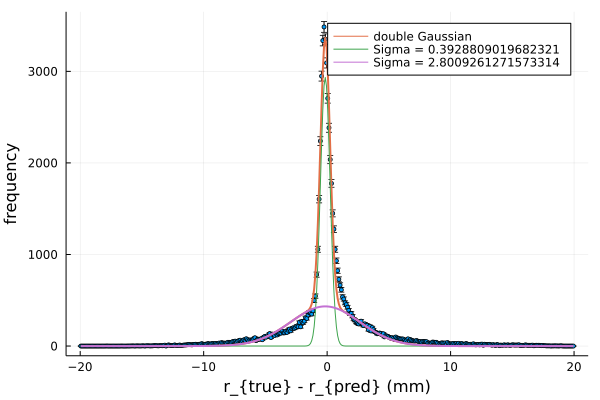

In [27]:
x_vals = ATools.centers(hpres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hpres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hpres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hpres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hpres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hpres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hzres.weights) * 100, sigma_all * 100]
p0 = [sum(hpres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hpres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hpres.weights), p0, lb, ub)

fitmeanp = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanp, ", ", sigma1, ", ", sigma2)
ppres = plot!(ppres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
ppres = plot!(ppres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
ppres = plot!(ppres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(ppres)

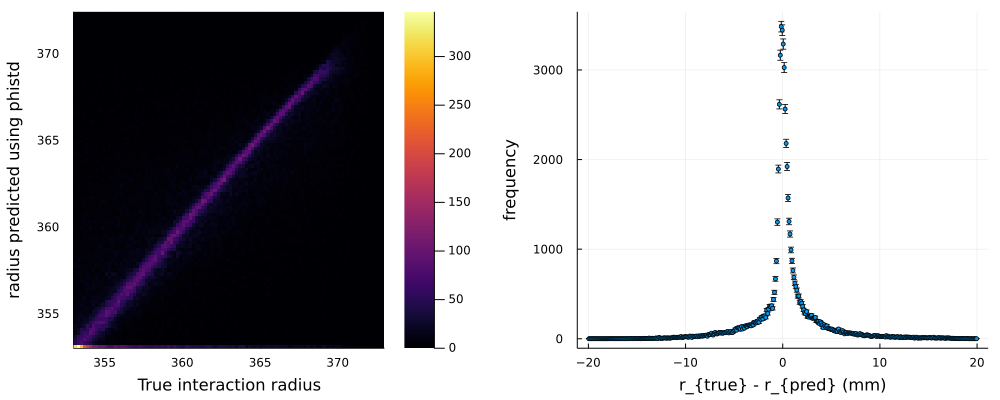

In [28]:
ppredr = ATools.predict_interaction_radius(fpr.g, rmin, rmax, fitmeanp)(ring_df.phistd)
_, pRpres = hist2d(ring_df.r, Float32.(ppredr), 100, "True interaction radius", "radius predicted using phistd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hpres, ppres  = hist1d(Float32.(ring_df.r - ppredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRpres, ppres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

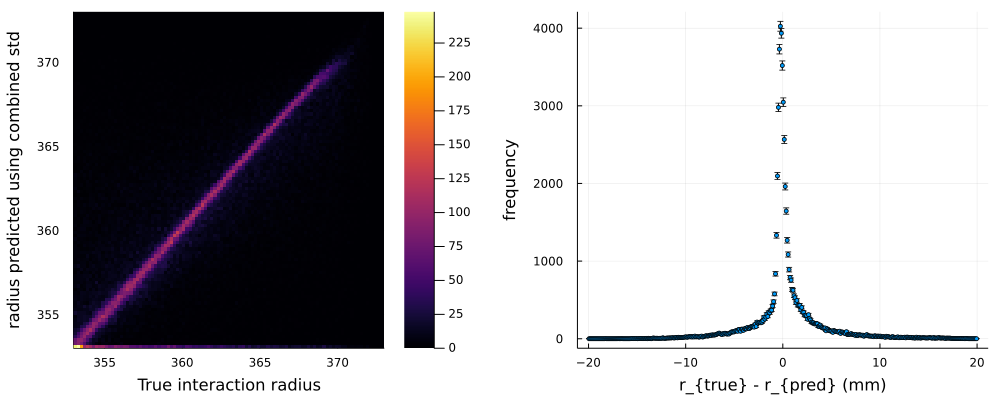

In [29]:
cpredr = ATools.predict_interaction_radius(fcr.g, rmin, rmax)(ring_df.stdrad)
_, pRcres = hist2d(ring_df.r, Float32.(cpredr), 100, "True interaction radius", "radius predicted using combined std", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hcres, pcres  = hist1d(Float32.(ring_df.r - cpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRcres, pcres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.15961884976232965, 0.3233771097542474, 2.6202296475573084


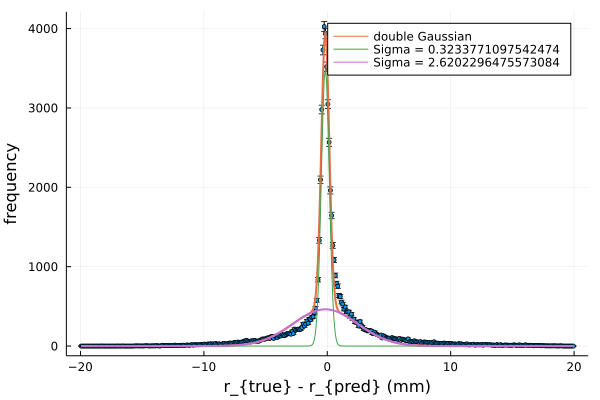

In [30]:
x_vals = ATools.centers(hcres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hcres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hcres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hcres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hcres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hcres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hcres.weights) * 100, sigma_all * 100]
p0 = [sum(hcres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hcres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hcres.weights), p0, lb, ub)

fitmeanc = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanc, ", ", sigma1, ", ", sigma2)
pcres = plot!(pcres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
pcres = plot!(pcres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
pcres = plot!(pcres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(pcres)

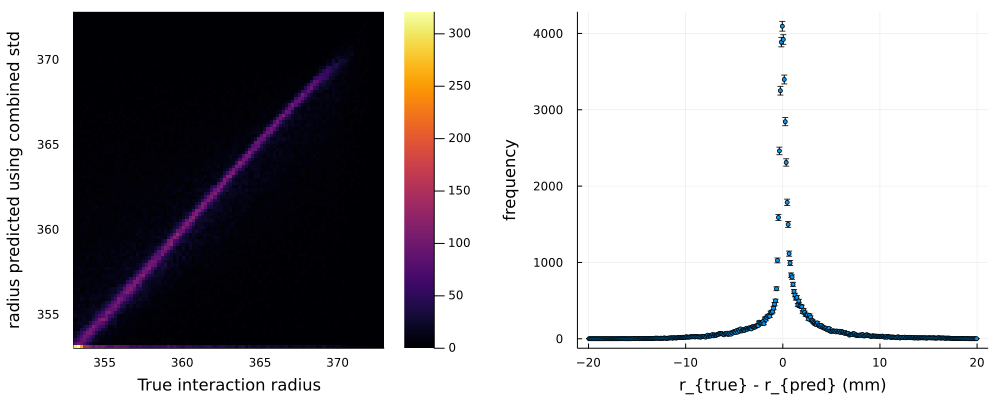

In [31]:
cpredr = ATools.predict_interaction_radius(fcr.g, rmin, rmax, fitmeanc)(ring_df.stdrad)
_, pRcres = hist2d(ring_df.r, Float32.(cpredr), 100, "True interaction radius", "radius predicted using combined std", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hcres, pcres  = hist1d(Float32.(ring_df.r - cpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRcres, pcres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

## Combination slightly better predictor, use it in this version

In [32]:
rpred = ATools.predict_interaction_radius(fcr.g, rmin, rmax, fitmeanc)
ndfq[!, :r1x] = rpred(combined_std(ndfq, :zstd1, :phistd1))
ndfq[!, :r2x] = rpred(combined_std(ndfq, :zstd2, :phistd2));

In [33]:
xp1, yp1, zp1 = ATools.radial_correction(ndfq.xr1, ndfq.yr1, ndfq.zr1, ndfq.r1x);
xp2, yp2, zp2 = ATools.radial_correction(ndfq.xr2, ndfq.yr2, ndfq.zr2, ndfq.r2x);

In [34]:
fg, px1 = fitg1(ndfq.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σx1 = ", fg.std[1], " mm")
fg, py1 = fitg1(ndfq.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σy1 = ", fg.std[1], " mm")
fg, pz1 = fitg1(Float64.(ndfq.zt1 - zp1), "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σz1 = ", fg.std[1], " mm")

 σx1 = 0.4333689698079032 mm
 σy1 = 0.43374538508646243 mm
 σz1 = 0.4237024783145382 mm


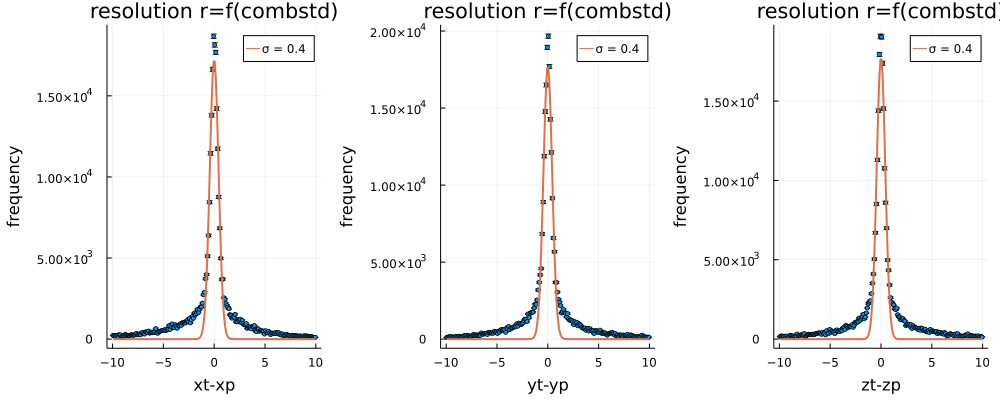

In [35]:
plot(px1, py1, pz1, layout= (1, 3), title="resolution r=f(combstd)", legend=true, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

x-x(rcomb) σ1 = 2.8543755297366835 σ2 = 0.3510321032735655
y-y(rcomb) σ1 = 2.5707694107464936 σ2 = 0.34799305881440473
z-z(rcomb) σ1 = 2.530155666651378 σ2 = 0.3450894702425379


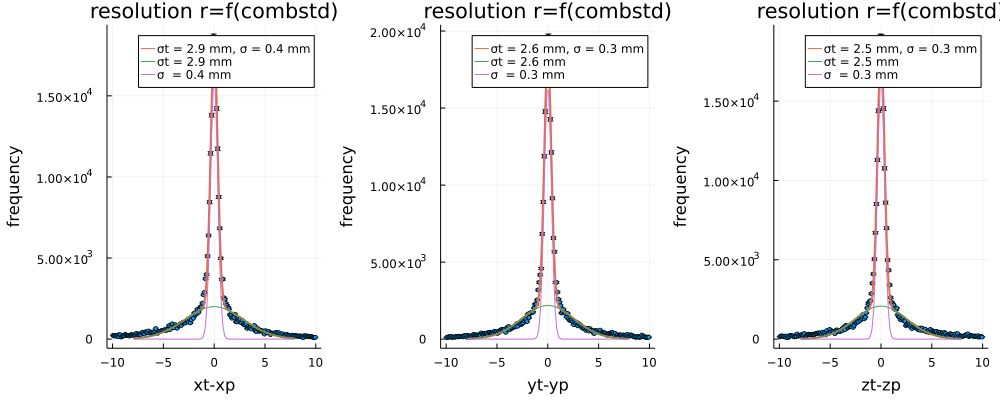

In [36]:
fg, px = fitg2(ndfq.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("x-x(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])

fg, py = fitg2(ndfq.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("y-y(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])

fg, pz = fitg2(Float64.(ndfq.zt1 - zp1), "zt-zp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("z-z(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])
plots_res = plot(px, py, pz, layout= (1, 3), title="resolution r=f(combstd)", legend=true, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [37]:

png(plots_res, joinpath(plot_path, "xyz_interaction_resolution"))

In [38]:
## Get the true interaction radius (Why not saved?)
transform!(ndfq, [:xt1, :yt1] => ((x, y) -> sqrt.(x.^2 + y.^2)) => :rt1, [:xt2, :yt2] => ((x, y) -> sqrt.(x.^2 + y.^2)) => :rt2);
units_ndfq = ATools.set_units(ndfq);

first photoelectron, position reco: FWHM = 222.285847973988, FWHM2 = 32.475115178350016


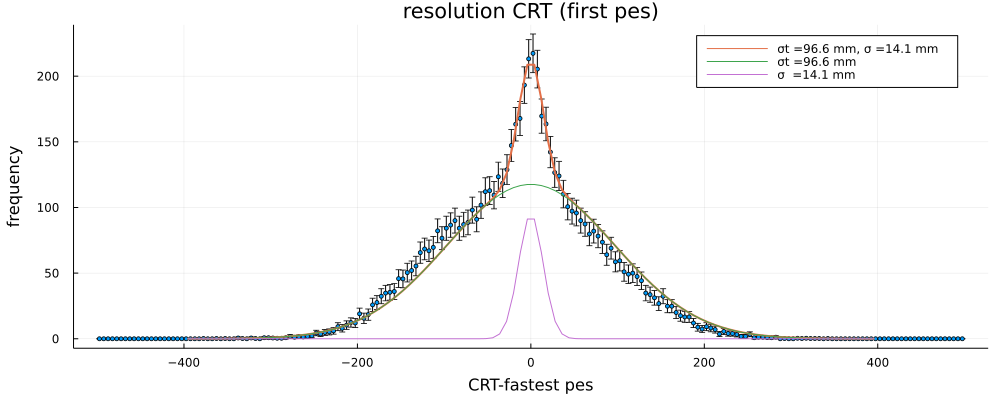

In [39]:
dt = ATools.CRT(units_ndfq, [:t1, :t2], [:rt1, :rt2], rmax)
fg,p = fitg2(dt, "CRT-fastest pes", 200, -500.0, 500.0, xg1min=-400.0, xg1max=-50.0, xg2min=-50.0,  xg2max =50.0, xgmin =-400.0, xgmax  =400.0)
println("first photoelectron, position reco: FWHM = ", 2.3*fg.std[1], ", FWHM2 = ", 2.3*fg.std[2])
best_crt = plot(p, title="resolution CRT (first pes)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [40]:
png(best_crt, joinpath(plot_path, "crt_limit_truth"))

fastest photoelectron, position reco: FWHM = 244.27882786720093


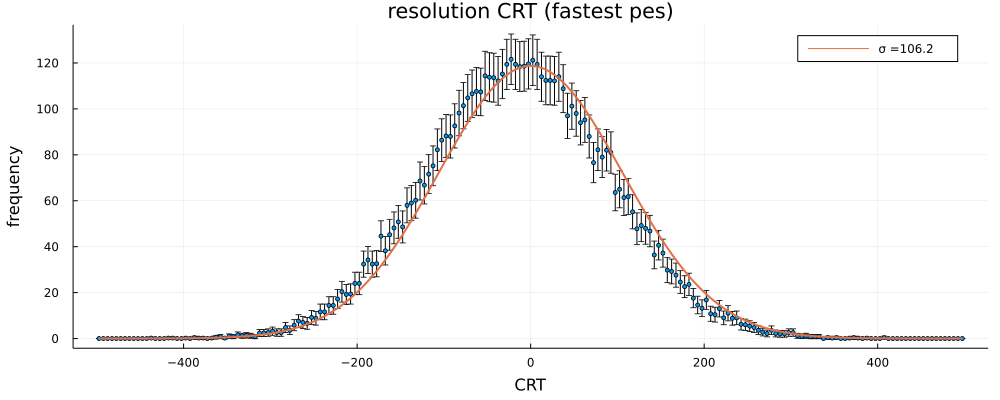

In [41]:
dt = ATools.CRT(units_ndfq, [:tr1, :tr2], [:rt1, :rt2], rmax)
fg, p = fitg1(dt, "CRT", 200, -500.0, 500.0, xgmin=-400.0, xgmax=400.0)
println("fastest photoelectron, position reco: FWHM = ", 2.3*fg.std[1])
fast_crt = plot(p, title="resolution CRT (fastest pes)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [42]:
png(fast_crt, joinpath(plot_path, "crt_fastSi_rtruth"))

fastest photoelectron, position reco: FWHM = 227.24175878040046


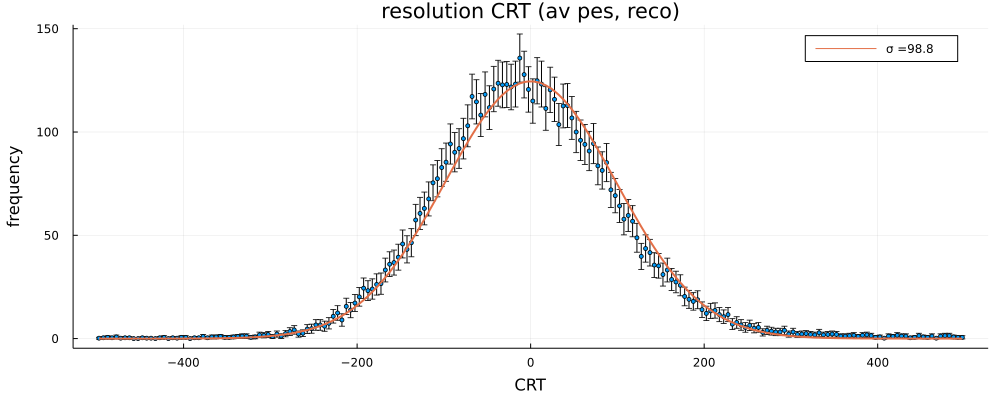

In [43]:
dt = ATools.CRT(units_ndfq, [:ta1, :ta2], [:r1x, :r2x], rmax)
fg, p = fitg1(dt, "CRT", 200, -500.0, 500.0, xgmin=-400.0, xgmax=400.0)
println("fastest photoelectron, position reco: FWHM = ", 2.3*fg.std[1])
reco_crt = plot(p, title="resolution CRT (av pes, reco)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [44]:
png(reco_crt, joinpath(plot_path, "crt_avSi_recoR"))

# For now we're going to save the calibration constants and calculate and save LOR info here. This should be formalised better.

In [45]:
#xp1, yp1, zp1, xp2, yp2, zp2
mlor_filename = joinpath(plot_path, config[1:end-1] * "_mlor.h5")
## LXe refraction index
nLXe = 1.69
t1   = ATools.interaction_time(units_ndfq, :r1x, :ta1, rmax, nLXe)
t2   = ATools.interaction_time(units_ndfq, :r2x, :ta2, rmax, nLXe)
mLor = ATools.MlemLor.((t2 - t1) ./ps, xp1, yp1, zp1, xp2, yp2, zp2)
ATools.write_lors_hdf5(mlor_filename, mLor)

In [46]:
## Cutre save of calibration info.
if conf.save_cal
  h5open("../config/radius_calibration.h5", "cw") do h5cal
    grp = haskey(h5cal, config) ? h5cal[config] : create_group(h5cal, config)
    attributes(grp)["zstd-bias"]  = fitmeanz
    attributes(grp)["zstd-const"] = fzr.fitpar[1]
    attributes(grp)["zstd-lin"]   = fzr.fitpar[2]
    attributes(grp)["pstd-bias"]  = fitmeanp
    attributes(grp)["pstd-const"] = fpr.fitpar[1]
    attributes(grp)["pstd-lin"]   = fpr.fitpar[2]
    attributes(grp)["cstd-bias"]  = fitmeanc
    attributes(grp)["cstd-const"] = fcr.fitpar[1]
    attributes(grp)["cstd-lin"]   = fcr.fitpar[2]
  end
end
  

-0.8005369585530829

# NEMA5

In [48]:
println(names(ndfq))

["event_id", "phot1", "phot2", "nsipm1", "nsipm2", "q1", "q2", "r1", "r2", "r1x", "r2x", "phistd1", "phistd2", "widphi1", "widphi2", "zstd1", "zstd2", "widz1", "widz2", "corrzphi1", "corrzphi2", "xt1", "xt2", "yt1", "yt2", "zt1", "zt2", "t1", "t2", "x1", "x2", "y1", "y2", "z1", "z2", "xr1", "xr2", "yr1", "yr2", "zr1", "zr2", "tr1", "tr2", "xb1", "xb2", "yb1", "yb2", "zb1", "zb2", "ta1", "ta2", "xs", "ux", "ys", "uy", "zs", "uz", "rt1", "rt2"]


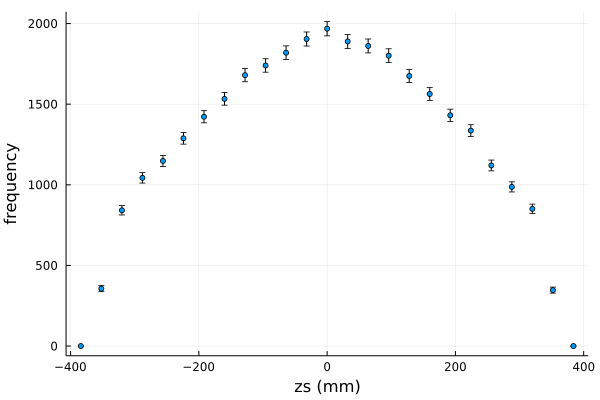

In [50]:
h,p = hist1d(ndfq.zs, "zs (mm)", 25, -400.0f0, 400.0f0, norm=false)
plot(p)

In [51]:
revents = sum(h.weights)
println("events recorded in z bins =", h.weights)
println("sensitivity per bin =", h.weights/norm)
println("sensitivity  (%) =", 100 * revents/norm)


events recorded in z bins =[0, 356, 842, 1043, 1148, 1288, 1422, 1533, 1680, 1740, 1819, 1904, 1968, 1889, 1861, 1801, 1675, 1563, 1431, 1336, 1120, 987, 851, 347, 0]
sensitivity per bin =[0.0, 0.00023733333333333335, 0.0005613333333333333, 0.0006953333333333333, 0.0007653333333333334, 0.0008586666666666666, 0.000948, 0.001022, 0.00112, 0.00116, 0.0012126666666666666, 0.0012693333333333333, 0.001312, 0.0012593333333333334, 0.0012406666666666666, 0.0012006666666666667, 0.0011166666666666666, 0.001042, 0.000954, 0.0008906666666666667, 0.0007466666666666666, 0.000658, 0.0005673333333333333, 0.00023133333333333334, 0.0]
sensitivity  (%) =2.1069333333333335


In [52]:
hs =  h.weights / norm;
he = 0.001* sqrt.(hs);

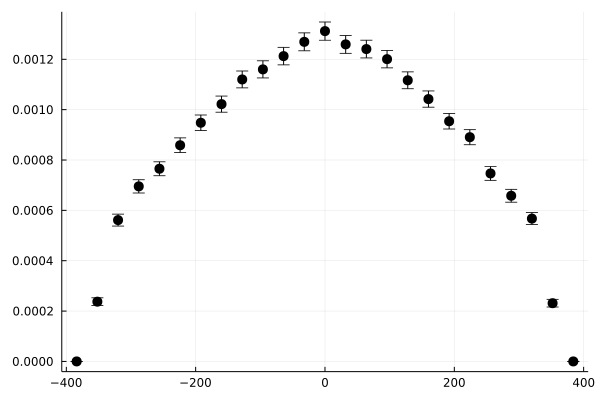

In [53]:
p1 = scatter(centers(h),hs, yerror=he,
	          shape = :circle, markersize=6, color = :black, legend=false, fmt = :png)

## normalize to counts per MBq

In [57]:
N = 1e+6 # 1 MBq
hA = hs * N
he = sqrt.(hA);

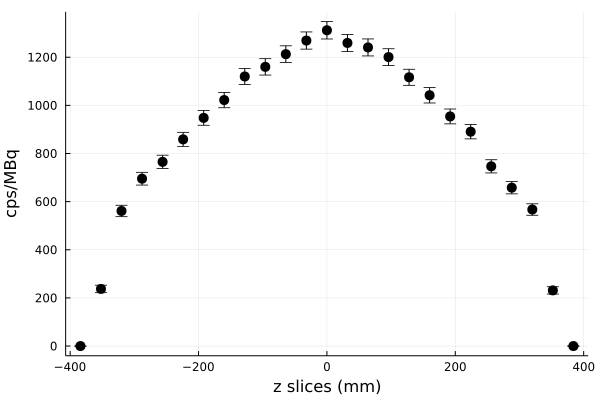

In [58]:
p2 = scatter(centers(h),hA, yerror=he,
	          shape = :circle, markersize=6, color = :black, legend=false, fmt = :png)
xlabel!("z slices (mm)")
ylabel!("cps/MBq")